# Damped pendulum and prediction by SciNet

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

from tqdm import tqdm
from pathlib import Path
import gc

## 1. We create data: sinusoidal amortized wave

In [2]:
def data_synthetic_pendulum(kapa, b, timesteps=50, maxtime=5.0, m=1.0, A0=1.0, phi=0.0, t: np.array = None):
    if t is None:
        t = np.linspace(0, maxtime, timesteps)
    w = np.sqrt(kapa / m) * np.sqrt(1 - b**2/(4*m*kapa))
    A = A0 * np.exp(-b * t / (2*m))

    return A * np.cos(w * t + phi)

In [3]:
def plot_synthetic_pendulum(timeserie, timesteps=50, maxtime=5.0):
    t = np.linspace(0, maxtime, timesteps)
    y = timeserie
    plt.figure(figsize=(10, 6))
    plt.plot(t, y)
    plt.title(f'Synthetic Pendulum')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.show()

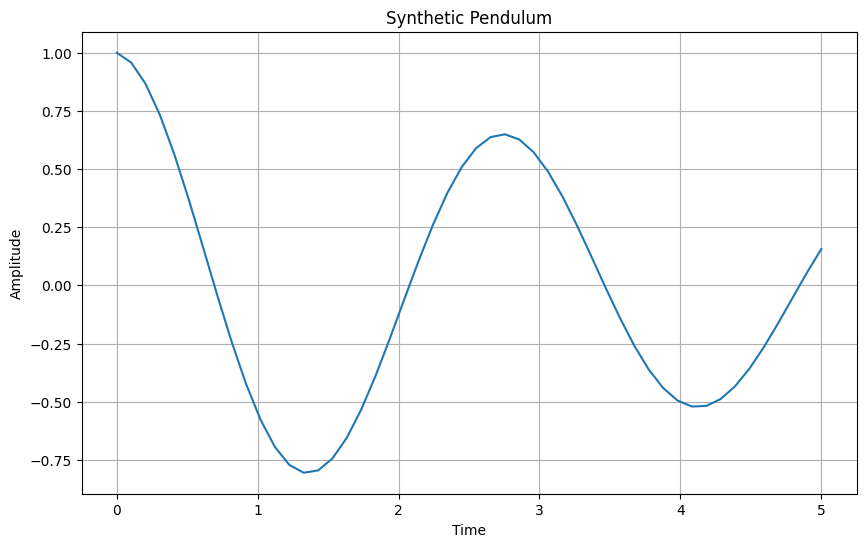

In [ ]:
kapa_range = (5.0, 6.0)
b_range = (0.2, 0.5)
kapa = np.random.uniform(*kapa_range)
b = np.random.uniform(*b_range)
pendulum1 = data_synthetic_pendulum(kapa, b)
plot_synthetic_pendulum(pendulum1)

In [5]:
def build_dataset(num_samples=1000, kapa_range=(3.0, 8.0), b_range=(0.1, 1.0), maxtime=5.0, timesteps=50):
    observations = []
    questions = []
    params = []
    a_corr = []
    for _ in range(num_samples):
        # Build observations
        kapa = np.random.uniform(*kapa_range)
        b = np.random.uniform(*b_range)
        params.append((kapa, b))
        timeserie = data_synthetic_pendulum(kapa, b, timesteps=timesteps, maxtime=maxtime)
        observations.append(timeserie)
        # Build questions
        question = np.random.uniform(timesteps, timesteps*2)
        questions.append(question)
        # Build answer to the question
        a_corr.append(data_synthetic_pendulum(kapa, b, t=np.array(question), maxtime=maxtime, timesteps=50))
    return np.array(observations), np.array(questions), np.array(a_corr), np.array(params)

In [6]:
class PendulumDataset(Dataset):
    def __init__(self, observations, questions, answers, params):
        self.observations = torch.tensor(observations, dtype=torch.float32)
        self.questions = torch.tensor(questions, dtype=torch.float32)
        self.answers = torch.tensor(answers, dtype=torch.float32)
        self.params = torch.tensor(params, dtype=torch.float32)

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        return self.observations[idx], self.questions[idx], self.answers[idx], self.params[idx]

In [7]:
N_samples = 10000
kapa_range = (5.0, 6.0)
b_range = (0.2, 0.5)
observations, questions, answers, params = build_dataset(N_samples, kapa_range, b_range)

dataset = PendulumDataset(observations, questions, answers, params)

In [8]:
train_valid_rate = 0.8
train_size = int(train_valid_rate * len(dataset))
valid_size = len(dataset) - train_size

train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])

## 2. Create SciNet

In [9]:
class SciNetEncoder(nn.Module):
    def __init__(self, 
                 input_size: int = 50, 
                 latent_size: int = 3, 
                 hidden_sizes: list[int] = [128, 64]
                 ) -> None:
        super().__init__()
        self.input_sizes = [input_size] + hidden_sizes[:-1]
        self.output_sizes = hidden_sizes
        self.layers = nn.ModuleList(
            [nn.Linear(in_size, out_size) for in_size, out_size in zip(self.input_sizes, self.output_sizes)]
        )
        self.activations = nn.ModuleList(
            [nn.ELU() for _ in range(len(hidden_sizes))]
        )
        self.mean_layer = nn.Linear(hidden_sizes[-1], latent_size)
        self.logvar_layer = nn.Linear(hidden_sizes[-1], latent_size)

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor]:
        for layer, activation in zip(self.layers, self.activations):
            x = activation(layer(x))
        mean = self.mean_layer(x)
        logvar = self.logvar_layer(x)
        return mean, logvar

In [10]:
# Test Encoder
batch_size = 10
input_size = 50
latent_size = 3
hidden_sizes = [128, 64]

x = torch.randn((batch_size, input_size))
encoder = SciNetEncoder(input_size=input_size, latent_size=latent_size, hidden_sizes=hidden_sizes)
mean, logvar = encoder(x)

assert mean.shape == (batch_size, latent_size)
assert logvar.shape == (batch_size, latent_size)

torch.cuda.empty_cache()
del x, encoder, mean, logvar
gc.collect()

3293

In [11]:
class QuestionDecoder(nn.Module):
    def __init__(self, 
                 latent_size: int = 3, 
                 question_size: int = 1, 
                 output_size: int = 1, 
                 hidden_sizes: list = [64, 32]
                 ) -> None:
        super().__init__()
        self.input_sizes = [latent_size + question_size] + hidden_sizes
        self.output_sizes = hidden_sizes + [output_size]
        self.layers = nn.ModuleList(
            [nn.Linear(in_size, out_size) for in_size, out_size in zip(self.input_sizes, self.output_sizes)]
        )
        self.activations = nn.ModuleList(
            [nn.ELU() for _ in range(len(hidden_sizes))] + [nn.Identity()]
        )

    def forward(self, z: torch.Tensor, question: torch.Tensor) -> torch.Tensor:
        z = torch.cat([z, question], dim=-1)
        for layer, activation in zip(self.layers, self.activations):
            z = activation(layer(z))
        return z

In [12]:
# Test Decoder
batch_size = 10
latent_size = 3
question_size = 1
hidden_sizes = [64, 32]
output_size = 1

x = torch.randn((batch_size, latent_size))
question = torch.randn((batch_size, question_size))
decoder = QuestionDecoder(latent_size=latent_size, question_size=question_size, output_size=output_size, hidden_sizes=hidden_sizes)
possible_answer = decoder(x, question)

assert possible_answer.shape == (batch_size, output_size)

torch.cuda.empty_cache()
del x, question, decoder, possible_answer
gc.collect()

0

In [13]:
class PendulumNet(nn.Module):
    def __init__(self, 
                 input_size: int = 50, 
                 enc_hidden_sizes: list[int] = [500, 100], 
                 latent_size: int = 10, 
                 question_size: int = 1,
                 dec_hidden_sizes: list[int] = [100, 100], 
                 output_size: int = 1
                 ) -> None:
        super().__init__()
        self.encoder = SciNetEncoder(input_size=input_size, latent_size=latent_size, hidden_sizes=enc_hidden_sizes)
        self.decoder = QuestionDecoder(latent_size=latent_size, question_size=question_size, output_size=output_size, hidden_sizes=dec_hidden_sizes)


    def forward(self, x, question):
        mean, logvar = self.encoder(x)
        z = self.reparametrize(mean, logvar)
        possible_answer = self.decoder(z, question)
        return possible_answer, mean, logvar

    def reparametrize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

In [14]:
# Test PendulumNet

batch_size = 10
input_size
enc_hidden_sizes = [128, 64]
latent_size = 3
question_size = 1
dec_hidden_sizes = [64, 32]
output_size = 1

x = torch.randn((batch_size, input_size))
question = torch.randn((batch_size, question_size))
model = PendulumNet(input_size=input_size, enc_hidden_sizes=enc_hidden_sizes, latent_size=latent_size, question_size=question_size, dec_hidden_sizes=dec_hidden_sizes, output_size=output_size)
possible_answer, mean, logvar = model(x, question)

assert possible_answer.shape == (batch_size, output_size)
assert mean.shape == (batch_size, latent_size)
assert logvar.shape == (batch_size, latent_size)

torch.cuda.empty_cache()
del model, x, question, possible_answer, mean, logvar
gc.collect()

0

In [15]:
def scinet_loss(
        possible_answer: torch.Tensor, 
        a_corr: torch.Tensor, 
        mean: torch.Tensor, 
        logvar: torch.Tensor, 
        beta: float = 0.001
        ) -> torch.Tensor:
    # prediction_loss = nn.MSELoss(reduction='none')(possible_answer, a_corr)
    # kld_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp(), dim=1).unsqueeze(-1)
    # total_loss = prediction_loss + beta * kld_loss
    # return torch.mean(total_loss)

    recon_loss = nn.MSELoss()(possible_answer.squeeze(), a_corr.squeeze())
    kld_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp(), dim=1).mean()
    return recon_loss + beta * kld_loss, kld_loss, recon_loss

In [16]:
# Test loss function

batch_size = 10
input_size
enc_hidden_sizes = [500, 100]
latent_size = 3
question_size = 1
dec_hidden_sizes = [100, 100]
output_size = 1

x = torch.randn((batch_size, input_size))
question = torch.randn((batch_size, question_size))
model = PendulumNet(input_size=input_size, enc_hidden_sizes=enc_hidden_sizes, latent_size=latent_size, question_size=question_size, dec_hidden_sizes=dec_hidden_sizes, output_size=output_size)
possible_answer, mean, logvar = model(x, question)

a_corr = torch.randn((batch_size, output_size))
beta = 0.01
loss = scinet_loss(possible_answer, a_corr, mean, logvar, beta)

assert loss[0].shape == ()
assert len(loss) == 3

torch.cuda.empty_cache()
del model, x, question, possible_answer, mean, logvar, a_corr, loss
gc.collect()

0

## 3. Training loop

In [17]:
from magnetics_diagnostic_analysis.ml_tools.train_callbacks import EarlyStopping, GradientClipping, LRScheduling

In [ ]:
# Params

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
batch_size1 = 512
batch_size2 = 512

m_input_size = 50
m_enc_hidden_sizes = [500, 100]
m_latent_size = 3
m_question_size = 1
m_dec_hidden_sizes = [100, 100]
m_output_size = 1

learning_rate = 1e-4
num_epochs = 150
kld_beta = 0.01
es_patience = 7
es_min_delta = 1e-4
gc_max_grad_norm = 1.0
lrs_factor = 0.66
lrs_patience = 5
lrs_min_lr = 1e-8
lrs_min_delta = 1e-4

Using device: cuda


In [19]:
train_loader = DataLoader(train_dataset, batch_size=batch_size1, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size2, shuffle=False)

In [20]:
pendulum_net = PendulumNet(
    input_size=m_input_size, 
    enc_hidden_sizes=m_enc_hidden_sizes, 
    latent_size=m_latent_size, 
    question_size=m_question_size, 
    dec_hidden_sizes=m_dec_hidden_sizes, 
    output_size=m_output_size
)

optimizer = torch.optim.Adam(pendulum_net.parameters(), lr=learning_rate)
early_stopper = EarlyStopping(patience=es_patience, min_delta=es_min_delta)
gradient_clipper = GradientClipping(max_norm=gc_max_grad_norm)
lr_scheduler = LRScheduling(optimizer, factor=lrs_factor, patience=lrs_patience, min_lr=lrs_min_lr, min_delta=lrs_min_delta)

In [21]:
# Training loop

def train_scinet(
        train_loader: DataLoader, 
        valid_loader: DataLoader,
        model: nn.Module, 
        optimizer: torch.optim.Optimizer, 
        num_epochs: int = 150, 
        kld_beta: float = 0.001, 
        early_stopper: EarlyStopping = None, 
        gradient_clipper: GradientClipping = None, 
        lr_scheduler: LRScheduling = None,
        device: torch.device = torch.device('cpu')
        ) -> None:
    
    torch.cuda.empty_cache()
    model.to(device)
    print("------training on {}-------\n".format(device))
    history = {'train_loss': [], 'valid_loss': []}
    print(f"{'Epoch':<20} ||| {'Train Loss':<15} ||| {'KLD Loss':<12} {'Recon Loss':<12} ||||||| {'Valid Loss':<15}")

    # Training
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        kld_loss, recon_loss = 0.0, 0.0
        for observations, questions, a_corr, _ in tqdm(train_loader, desc="Training", leave=False):
            observations = observations.to(device)
            questions = questions.to(device).unsqueeze(-1)
            a_corr = a_corr.to(device).unsqueeze(-1)

            optimizer.zero_grad()
            possible_answer, mean, logvar = model(observations, questions)
            loss, l_kld, l_recon = scinet_loss(possible_answer, a_corr, mean, logvar, beta=kld_beta)
            loss.backward()
            if gradient_clipper is not None:
                gradient_clipper.on_backward_end(model)
            optimizer.step()

            train_loss += loss.item() * observations.size(0)
            kld_loss += l_kld.item() * observations.size(0)
            recon_loss += l_recon.item() * observations.size(0)
        train_loss /= len(train_loader.dataset)
        kld_loss /= len(train_loader.dataset)
        recon_loss /= len(train_loader.dataset)
        history['train_loss'].append(train_loss)

        # Evaluation
        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for observations, questions, a_corr, _ in tqdm(valid_loader, desc="Validation", leave=False):
                observations = observations.to(device)
                questions = questions.to(device).unsqueeze(-1)
                a_corr = a_corr.to(device).unsqueeze(-1)

                possible_answer, mean, logvar = model(observations, questions)
                loss = scinet_loss(possible_answer, a_corr, mean, logvar, beta=kld_beta)[0]
                valid_loss += loss.item() * observations.size(0)
        
        valid_loss /= len(valid_loader.dataset)
        history['valid_loss'].append(valid_loss)

        print(f"{f'{epoch+1}/{num_epochs}':<20}  |  {train_loss:<15.6f}  |  {kld_loss:<12.6f} {recon_loss:<12.6f}    |    {valid_loss:<15.6f}")

        if early_stopper is not None:
            if early_stopper.check_stop(valid_loss, model):
                print(f"Early stopping at epoch {epoch + 1} with loss {valid_loss:.4f}")
                print(f"Restoring best weights for model.")
                early_stopper.restore_best_weights(model)
                break

        if lr_scheduler is not None:
            lr_scheduler.step(valid_loss)

        path = Path().absolute() / 'pendulum_scinet.pth'
        torch.save(model.state_dict(), path)

        torch.cuda.empty_cache()
        gc.collect()
    
    return history

In [22]:
history = train_scinet(
    train_loader, 
    valid_loader, 
    pendulum_net, 
    optimizer, 
    num_epochs=num_epochs, 
    kld_beta=kld_beta, 
    early_stopper=early_stopper, 
    gradient_clipper=gradient_clipper, 
    lr_scheduler=lr_scheduler,
    device=device
)

------training on cuda-------

Epoch                ||| Train Loss      ||| KLD Loss     Recon Loss   ||||||| Valid Loss     


1/150                 |  0.548298         |  0.018842     0.548110        |    0.222038       


2/150                 |  0.224428         |  0.023254     0.224195        |    0.043571       


3/150                 |  0.043767         |  0.031578     0.043452        |    0.010498       


4/150                 |  0.010411         |  0.043860     0.009973        |    0.039033       


5/150                 |  0.039120         |  0.046898     0.038651        |    0.045868       


6/150                 |  0.045903         |  0.045235     0.045450        |    0.029503       


7/150                 |  0.029897         |  0.040703     0.029490        |    0.010187       


8/150                 |  0.009724         |  0.034633     0.009378        |    0.006621       


9/150                 |  0.006618         |  0.028014     0.006338        |    0.014855       


10/150                |  0.015239         |  0.024212     0.014997        |    0.016390       


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.58 GiB of which 119.94 MiB is free. Process 989265 has 135.45 MiB memory in use. Process 3475734 has 135.45 MiB memory in use. Process 3269986 has 135.51 MiB memory in use. Including non-PyTorch memory, this process has 210.00 MiB memory in use. Of the allocated memory 69.92 MiB is allocated by PyTorch, and 6.08 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [23]:
print(f"Mémoire GPU allouée: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
print(f"Mémoire GPU réservée: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")
print(f"Mémoire GPU maximale: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

Mémoire GPU allouée: 69.71 MB
Mémoire GPU réservée: 76.00 MB
Mémoire GPU maximale: 14.58 GB


In [ ]:
path = Path().absolute() / 'pendulum_scinet.pth'
torch.save(pendulum_net.state_dict(), path)

In [ ]:
def plot_history(history_train: list, history_valid: list) -> None:
    plt.figure(figsize=(8, 5))
    plt.plot(history_train, 'b-', linewidth=2, label='Train Loss')
    plt.plot(history_valid, 'r-', linewidth=2, label='Valid Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    #path = Path(__file__).absolute().parent.parent.parent.parent / "results/figures/mscred/last_training_history.png"
    #plt.savefig(path)
    plt.show()
    return None

In [ ]:
plot_history(history['train_loss'], history['valid_loss'])

## 4. Test on one example

In [ ]:
def make_prediction(model: nn.Module, observation: np.array, question: float, device: torch.device = torch.device('cpu')) -> float:
    torch.cuda.empty_cache()
    gc.collect()
    model.to(device).eval()
    observation_tensor = torch.tensor(observation, dtype=torch.float32).unsqueeze(0).to(device)
    question_tensor = torch.tensor([[question]], dtype=torch.float32).to(device)
    with torch.no_grad():
        possible_answer, _, _ = model(observation_tensor, question_tensor)
    return possible_answer.item()

In [ ]:
def plot_prediction(observation, question, answer, possible_answer) -> None:
    fig = plt.figure(figsize=(10, 6))
    plt.plot(observation, label='Observation', color='blue')
    plt.scatter(question, possible_answer, color='red', label='Prediction', zorder=5)
    plt.scatter(question, answer, color='green', label='True Answer', zorder=5)
    plt.title('Pendulum Prediction')
    plt.xlabel('Time Steps')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid()
    plt.show()
    return None

In [ ]:
N_samples = 1
kapa_range = (4.5, 5.5)
b_range = (0.4, 0.6)
observations, questions, answers, params = build_dataset(N_samples, kapa_range, b_range)

possible_answer = make_prediction(pendulum_net, observations[0], questions[0], device=device)
plot_prediction(observations[0], questions[0], answers[0], possible_answer)